# Waze: Customer Churn Prediction model

# We are implementing the **PACE** methodology which acts as a framework to simplify the process of building a machine learning model , 
# PACE classify the whole project to 4 stages :
  - ### Plan
  - ### Analyze
  - ### Construct
  - ### Execute

## **Pace: Plan**

###  The business scenario and problem

Waze’s free navigation app makes it easier for drivers around the world to get to where they want to go. Waze’s community of map editors, beta testers, translators, partners, and users helps make each drive better and safer. Waze partners with cities, transportation authorities, broadcasters, businesses, and first responders to help as many people as possible travel more efficiently and safely. 

The purpose of this project is to help prevent user churn on the Waze app. Churn quantifies the number of users who have uninstalled the Waze app or stopped using the app, on the other hand High retention rates indicate satisfied users who repeatedly use the Waze app over time.

**Developing a churn prediction model will help prevent churn, improve user retention, and grow Waze’s business. An accurate model can also help identify specific factors that contribute to churn and answer questions such as:**

Who are the users most likely to churn?

Why do users churn? 

When do users churn?


###  Evaluation Metric

Now which of these accuracy measures should we care about ? it depends on what we want the model to achieve.

**Accuracy** is a straight forward metric , but it may not be the most suitable metric in scenarios with imbalanced datasets , like the one we have her

**Precision** is useful when the cost of **false positives** is high.

**Recall** is useful when the cost of **false negatives** is high.

**f1-score**  is useful when there is an uneven class distribution or when there is an equal emphasis on both false positives and false negatives.

To determine which evaluation metric might be best, we should consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app.
  - **False negatives:** Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users, or send a survey to better understand user dissatisfaction.
  
**False positives** will cost Waze huge ammount of money and time to regain employees through notifications , adverising , marketing campaigns and more

**False negatives** is also very dangerous as it will lead to churn customers without being identified.

**Both False positive and False Negative costs are high , so we will evaluate the model based on a balance between both of them , which is F1-score**

## Step 1. Imports

### Import packages

In [65]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics  import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import precision_score  , recall_score , accuracy_score, f1_score
from sklearn.model_selection import train_test_split , GridSearchCV ,  PredefinedSplit

### Load dataset


In [2]:
# Load the main dataset
df0 = pd.read_csv("waze.csv")

In [3]:
# Display first few rows of the main dataset
df0.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


## Step 2. Data Exploration (Initial EDA and data cleaning)

### Identifying number of rows and columns in the dataset

In [4]:
df0.shape

(14999, 13)

### basic information about the data

In [5]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


### descriptive statistics about the data

In [6]:
# Gather descriptive statistics about the data
df0.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


### Check missing values

Check for any missing values in the data.

In [7]:
# Check for missing values
df0.isnull().sum()

ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

Dropping missing values

In [8]:
df0 = df0.dropna(axis=0)

Let's check that missing values are successfully dropped

In [9]:
df0.isnull().sum()

ID                         0
label                      0
sessions                   0
drives                     0
total_sessions             0
n_days_after_onboarding    0
total_navigations_fav1     0
total_navigations_fav2     0
driven_km_drives           0
duration_minutes_drives    0
activity_days              0
driving_days               0
device                     0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [10]:
# Check for duplicates
df0.duplicated().sum()

0

### Check outliers

We are going to use Naivebaise and tree based models in our experiments , which are robust to outliers so no need to drop them , however let's have a look at the dataset outliers

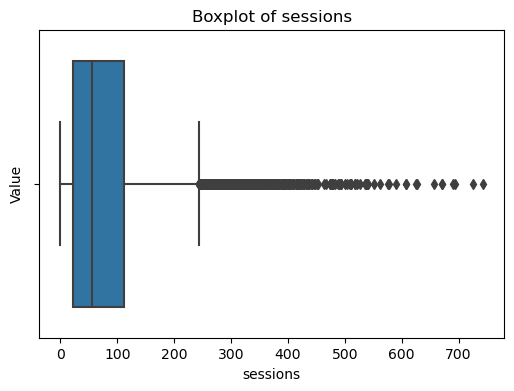

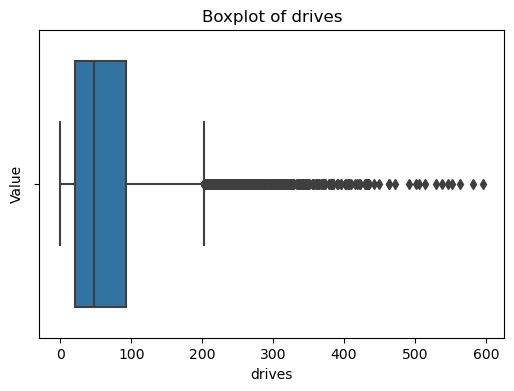

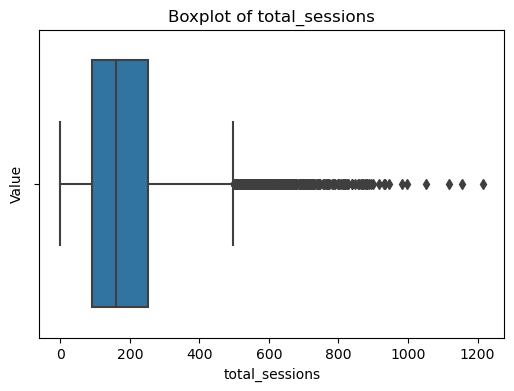

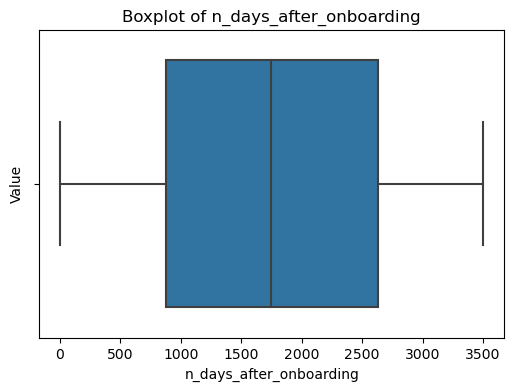

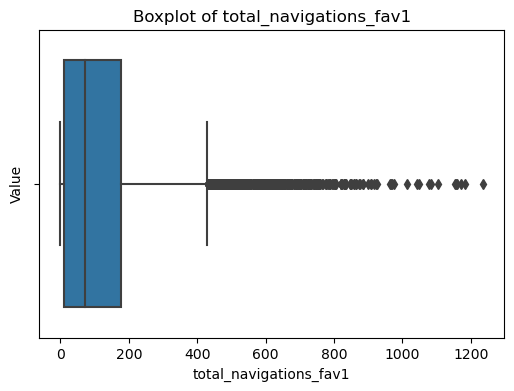

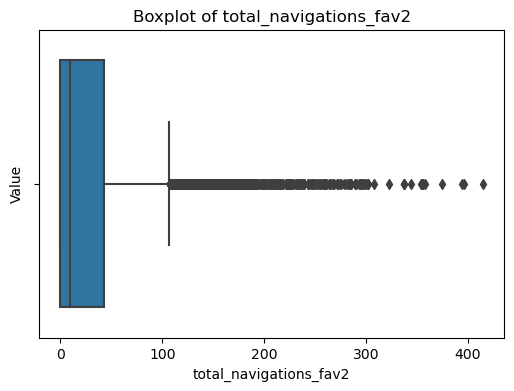

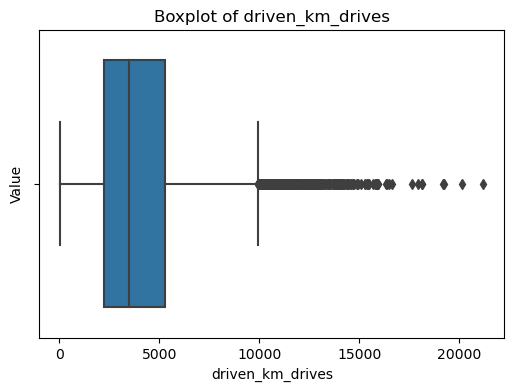

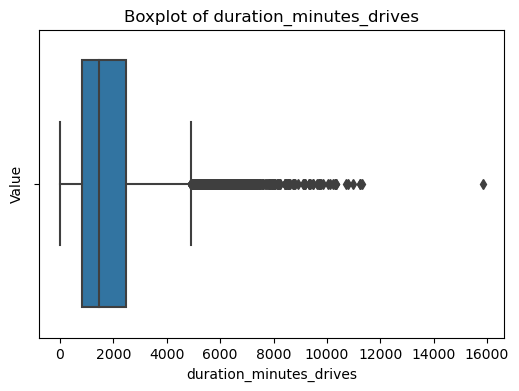

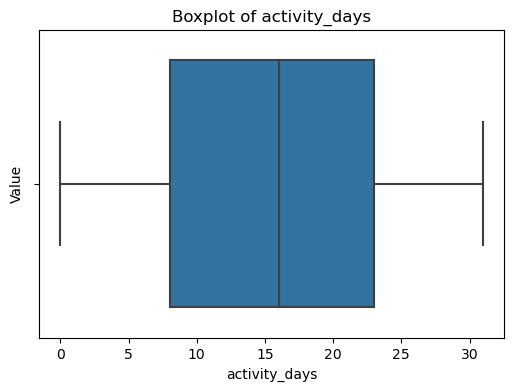

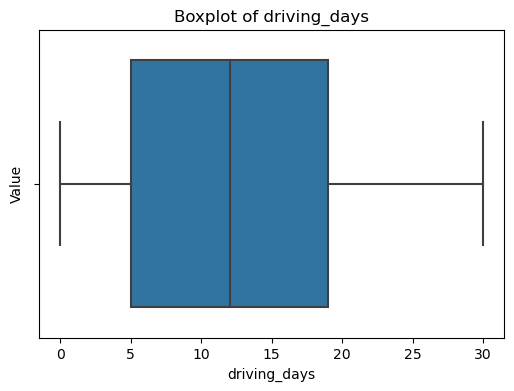

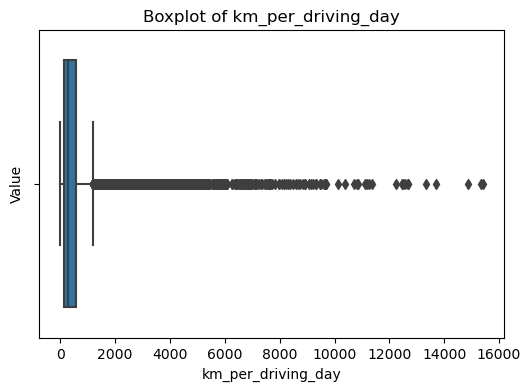

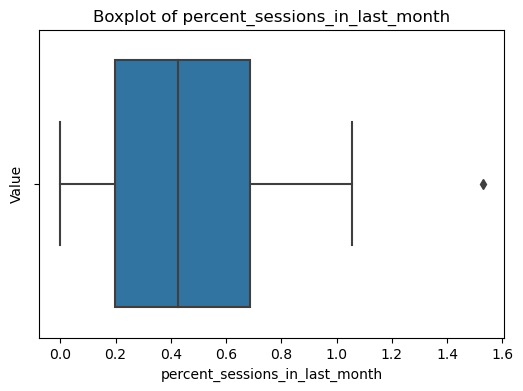

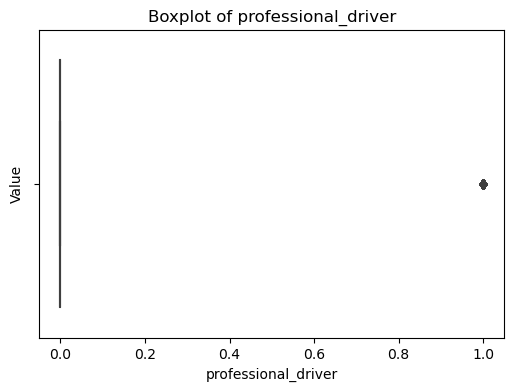

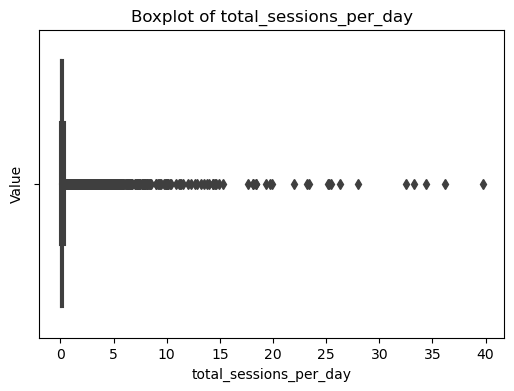

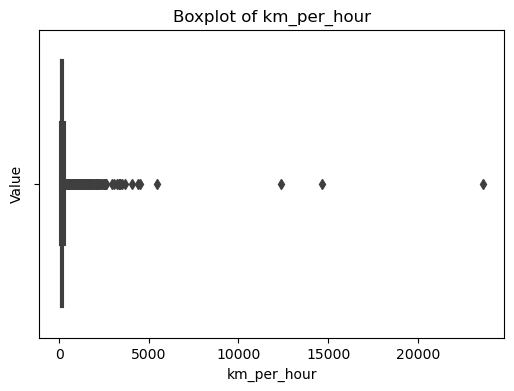

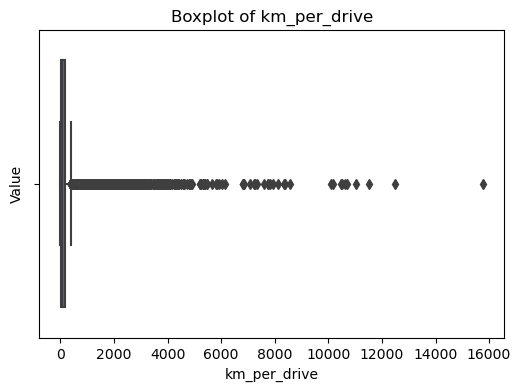

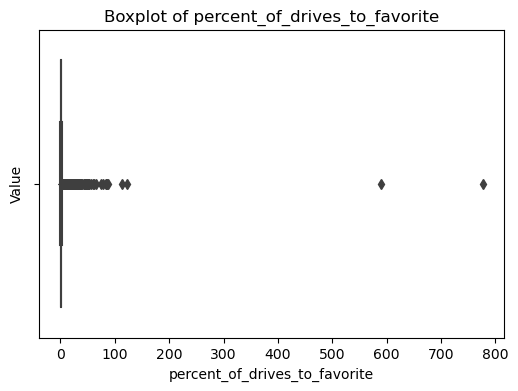

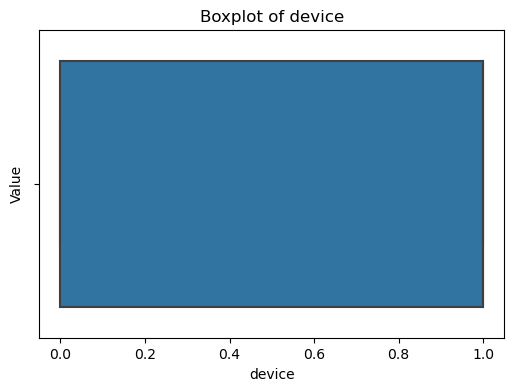

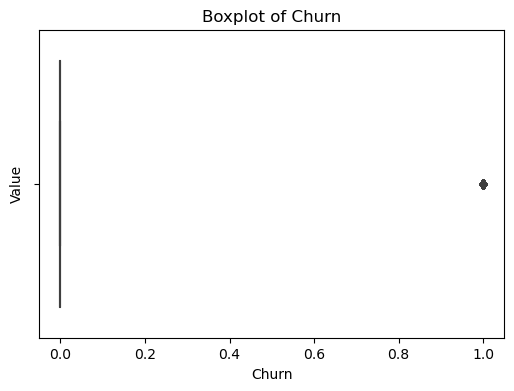

In [99]:
for column in df0.columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=column, data=df0)
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.show()

In [100]:
# Determine the number of rows containing outliers
for z in df0.columns:
    

    Q1 = df0[z].quantile(0.25)
    Q3 = df0[z].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify rows with at least one outlier
    outliers = ((df0[z] < lower_bound) | (df0[z] > upper_bound))

    print(f" {z} = {outliers.sum()}")

 sessions = 709
 drives = 695
 total_sessions = 500
 n_days_after_onboarding = 0
 total_navigations_fav1 = 682
 total_navigations_fav2 = 976
 driven_km_drives = 440
 duration_minutes_drives = 613
 activity_days = 0
 driving_days = 0
 km_per_driving_day = 1571
 percent_sessions_in_last_month = 1
 professional_driver = 2488
 total_sessions_per_day = 1677
 km_per_hour = 1330
 km_per_drive = 1729
 percent_of_drives_to_favorite = 1267
 device = 0
 Churn = 2536


# pAce: Analyze Stage

### Feature Engineering

First , let's engineer a feature called **`km_per_driving_day`** representing the mean number of kilometers driven on each driving day in the last month for each user.

In [11]:
#Creating `km_per_driving_day` feature
df0['km_per_driving_day'] = df0['driven_km_drives'] / df0['driving_days']

#Getting descriptive stats
df0['km_per_driving_day'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.241789e+02
75%      7.608293e+02
max               inf
Name: km_per_driving_day, dtype: float64

some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.
let's fix this

In [12]:
#Converting infinite values to zero
df0.loc[df0['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

#Confirming that it worked
df0['km_per_driving_day'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_driving_day, dtype: float64

Second , let's engineer a new a feature called **`percent_sessions_in_last_month`** that represents the percentage of each user's total sessions that were logged in their last month of use.

In [13]:
#Creating `percent_sessions_in_last_month` feature
df0['percent_sessions_in_last_month'] = df0['sessions'] / df0['total_sessions']

#Getting descriptive stats
df0['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.449837
std          0.286863
min          0.000000
25%          0.196890
50%          0.424310
75%          0.687251
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

Third , let's engineer a new, binary feature called `professional_driver` that represents  1 for users who had 60 or more drives **and** drove on 15+ days in the last month.

In [14]:
#Creating `professional_driver` feature
df0["professional_driver"] = ((df0["drives"] >= 60) & (df0["driving_days"] >=15))
df0["professional_driver"] = df0["professional_driver"].astype(int)

# Another way to achieve this by using Numpy
# df0['professional_driver'] = np.where((d0f['drives'] >= 60) & (df0['driving_days'] >= 15), 1, 0)

Fourth , let's engineer a feature called **`total_sessions_per_day`** that represents the mean number of sessions per day since onboarding.


In [15]:
# Creating `total_sessions_per_day` feature
df0['total_sessions_per_day'] = df0['total_sessions'] / df0['n_days_after_onboarding']
#Getting descriptive stats
df0['total_sessions_per_day'].describe()

count    14299.000000
mean         0.338207
std          1.319814
min          0.000298
25%          0.050818
50%          0.100457
75%          0.215210
max         39.763874
Name: total_sessions_per_day, dtype: float64

Fifth , let's engineer a feature called **`km_per_hour`** representing the mean kilometers per hour driven in the last month.

In [16]:
# Creating `km_per_hour` feature
df0['km_per_hour'] = df0['driven_km_drives'] / (df0['duration_minutes_drives'] / 60)
#Getting descriptive stats
df0['km_per_hour'].describe()

count    14299.000000
mean       190.730963
std        339.926138
min         72.013095
25%         90.649402
50%        122.105845
75%        193.238449
max      23642.920871
Name: km_per_hour, dtype: float64

Sixth , let's engineer a feature called **`km_per_drive`** representing the mean number of kilometers per drive made in the last month for each user 

In [17]:
# creating `km_per_drive` feature
df0['km_per_drive'] = df0['driven_km_drives'] / df0['drives']
#Getting descriptive stats
df0['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.325389e+01
50%      7.490594e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

looks like there are infinity values in this feature , let's do as we did before in a previous feature.

In [18]:
#Converting infinite values to zero
df0.loc[df0['km_per_drive']==np.inf, 'km_per_drive'] = 0

#Confirming that it worked
df0['km_per_drive'].describe()

count    14299.000000
mean       232.269197
std        616.197409
min          0.000000
25%         32.486524
50%         72.947059
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

Seventh and finally , let's create a feature called `percent_sessions_to_favorite` that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [19]:
# Creating `percent_of_sessions_to_favorite` feature
df0['percent_of_drives_to_favorite'] = (
    df0['total_navigations_fav1'] + df0['total_navigations_fav2']) / df0['total_sessions']

# Getting descriptive stats
df0['percent_of_drives_to_favorite'].describe()

count    14299.000000
mean         1.676347
std          9.021250
min          0.000000
25%          0.206064
50%          0.653572
75%          1.643183
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

let's have a look at the dataset after engineering !

In [20]:
df0.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0,0.106009,123.147688,8.749890,0.000000
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0,0.657570,433.471306,2624.586414,0.857534
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0,0.058711,191.944326,225.487213,0.000000
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0,0.432859,99.791944,57.645864,0.141665
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0,0.081682,154.838864,88.874416,0.294115


### Variable Encoding

We have two categorical variables in our dataset , `device` , and the target variable `label` , let's convert both of them to binary

In [21]:
#encoding device feature
df0['device2'] = np.where(df0['device']=='Android', 0, 1)
df0[['device', 'device2']].tail()

#Another method
#df0['device'] = df0['device'].replace({'retained': 0, 'churned': 1})


,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [22]:
#encoding label feature
df0['label2'] = np.where(df0['label']=='churned', 1, 0)
df0[['label', 'label2']].tail()

#Another way

##df0['label'] = df0['label'].replace({'Android': 0, 'iphone': 1})


,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


Now let's drop the old features `label` and `device` which will no longer be used , also there is a useless feature  called ID which should be dropped

In [23]:
# Drop columns
df0 = df0.drop(['label' , 'device' , 'ID'], axis=1)
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14299 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   sessions                        14299 non-null  int64  
 1   drives                          14299 non-null  int64  
 2   total_sessions                  14299 non-null  float64
 3   n_days_after_onboarding         14299 non-null  int64  
 4   total_navigations_fav1          14299 non-null  int64  
 5   total_navigations_fav2          14299 non-null  int64  
 6   driven_km_drives                14299 non-null  float64
 7   duration_minutes_drives         14299 non-null  float64
 8   activity_days                   14299 non-null  int64  
 9   driving_days                    14299 non-null  int64  
 10  km_per_driving_day              14299 non-null  float64
 11  percent_sessions_in_last_month  14299 non-null  float64
 12  professional_driver             

The target variable name `label` is not reresentative of it's nature , so let's rename it to `churn` , also we need to rename the variable `device2` to it's original name `device`

In [24]:
df0 = df0.rename(columns = {'label2':'Churn' , 'device2':'device'})
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14299 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   sessions                        14299 non-null  int64  
 1   drives                          14299 non-null  int64  
 2   total_sessions                  14299 non-null  float64
 3   n_days_after_onboarding         14299 non-null  int64  
 4   total_navigations_fav1          14299 non-null  int64  
 5   total_navigations_fav2          14299 non-null  int64  
 6   driven_km_drives                14299 non-null  float64
 7   duration_minutes_drives         14299 non-null  float64
 8   activity_days                   14299 non-null  int64  
 9   driving_days                    14299 non-null  int64  
 10  km_per_driving_day              14299 non-null  float64
 11  percent_sessions_in_last_month  14299 non-null  float64
 12  professional_driver             

### Check class balance

understanding how many customers are generous and how many are not generous

In [25]:
# Get numbers of people who are generous vs. not generous
df0['Churn'].value_counts()
# Get percentages of people who left vs. stayed
df0['Churn'].value_counts(normalize = True) *100

0    82.264494
1    17.735506
Name: Churn, dtype: float64

<Axes: >

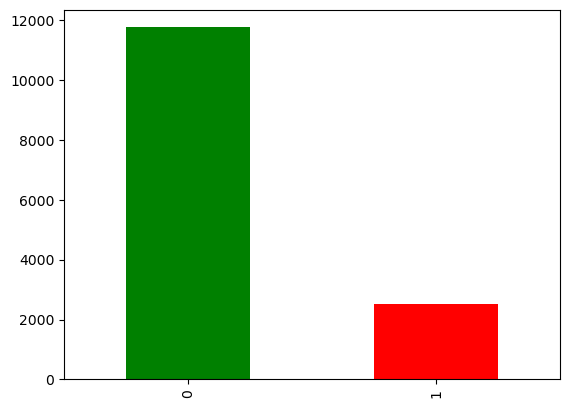

In [26]:
#visualizing class balance
df0['Churn'].value_counts().plot.bar(color=['green', 'red'])

unfortunately , the `Churn` target variable is not balanced , about 82% are retained (0) and 17% are churned (1) , however it's not considered extremely unabalanced so we won't go through any sampling.

# paCe: Construct Stage

## Step 3. Model Building

This is a classification task , since our target variable is categorical consisting of 0 and 1. 

we will proceed with two classifiers:
 - Random Forest
 - XGBOOST

### Modeling

In [27]:
# Identifying features and target variable
X = df0.drop(['Churn'] , axis = 1)
y = df0['Churn']

X.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_drives_to_favorite,device
0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0
1,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1
2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0
3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1
4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0


In [52]:
# Split dataset into training , validating holdout(test) datasets

#creating Training and testing sets
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size = 0.3 , stratify=y , random_state = 42)

#creating a validation set
X_tr , X_val , y_tr , y_val = train_test_split(X_train, y_train , test_size = 0.5,  stratify=y_train , random_state = 10)

Let's illustrate what we are doing here , simply we are splitting our dataset to training and testing set as normal , but we want to apply the **cross validation** technique , which means that we will train our model using the training data as normal , but we won't check the model accuracy on the test data , instead we will use our validation set to train all the models we are going to experiment.
now the question is what should be done with the test data 🤔 ????!
the test data will remain unseen until we finish building all the models , finally the champion model (the model with higher accuracy scores) will only be used to predict on the testing data 😎.
the following diagram illustrates the idea. 

Note: it's not a must to split the data 60 20 20 , in our case here , we are splitting it to 70 15 15



## Experiment 1: Random Forest

In [51]:
# Instantiate random forest model.
rf = RandomForestClassifier()

#### We should first first identify the best Hyper paramaters for the classifier using GridSearch

In [50]:
# Determine set of hyperparameters for random forest
rf_cv_params = {'n_estimators' : [50,100 , 150 , 200], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50],
             'min_samples_split': [2, 4, 6],
              'max_features' : ["sqrt"], 
              'max_samples' : [.5,.9]}

scoring = ['accuracy', 'precision', 'recall', 'f1']

GridSearchCV wants to cross validate the data. In fact, if the CV parameter was left blank, it would split the data into five folds for cross-validation by default. Because we are using a separate validation set, it's important to explicitly tell the function how to perform the validation. This includes telling it every row in the training and testing sets. we will use a **list comprehension** to generate a list of the same length as our X_tr data, where each value is either a negative one or a zero. Use this list to indicate to GridSearchCV that each row labeled negative 1 is in the training set and each row labeled as zero is in the validation set.

In [49]:
# Create list of split indices.
split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [54]:
%%time 
rf_val = GridSearchCV(rf, rf_cv_params, cv=custom_split, scoring = scoring ,  refit='f1', n_jobs = -1, verbose = 1)

# Fit the model
rf_val.fit(X_train , y_train)

Fitting 1 folds for each of 1680 candidates, totalling 1680 fits
CPU times: total: 5.03 s
Wall time: 3min 47s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1,  0])),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'max_features': ['sqrt'], 'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [2, 5, 10, 20, 50],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 150, 200]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [55]:
#getting the best paramaters to be used with Random forest
rf_val.best_params_

{'max_depth': 15,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 50}

#### We are going to use the confusion matrix & accuracy measures to test the accuracy of each model we will create , so let's create a function that takes three arguments , model , x_data and y_data , to prevent code duplication

In [56]:
#creating a confusion matrix to identify how accurate our classifier is
def conf_matrix_plot(model, x_data, y_data):
    model_pred = model.predict(x_data) # Save predictions
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_) # Calculate the values for each quadrant in the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot(values_format='')  # `values_format=''` this is written to prevent the numbers in the confusion matrix to appear in that form (1.5e+03) 
    plt.show()    
    
    #Accuracy reports
    report =    {"Accuracy" :accuracy_score(y_data, model_pred) , 
                "Precision": precision_score(y_data, model_pred),
                "Recall" : recall_score(y_data, model_pred) , 
                "F1 Score" : f1_score(y_data, model_pred)}
    for key , value  in report.items():
        print(f"{key}:{value.round(3)}")

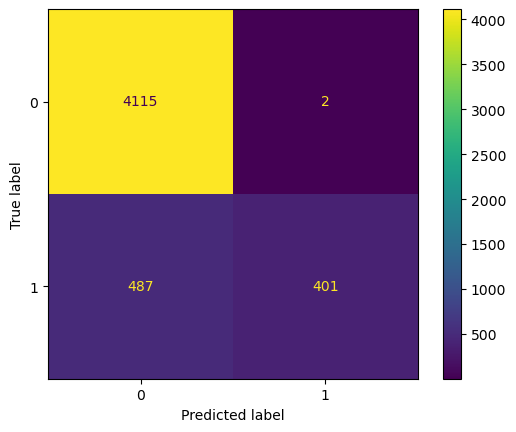

Accuracy:0.902
Precision:0.995
Recall:0.452
F1 Score:0.621


In [57]:
conf_matrix_plot(rf_val.best_estimator_, X_val, y_val)

## Experiment 2: Gradient boosting (XGBOOST)

#### In this experiment , let's use another tree-based ensemble model  ,  XGBOOST  

In [40]:
#Instantiate XGBOOST classifier
xgb = XGBClassifier(objective='binary:logistic')

In [41]:
# Determine set of hyperparameters for XGBOOST
xgb_cv_params = {'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50],
              'min_child_weight': [3, 5 , 10 , 15 , 20 , 30 , 50 , 70 , 100],
              'learning_rate': [0.1, 0.2, 0.3 , 0.5 ,0.7 ,0.9],
              'n_estimators': [50,100 , 150 , 200],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

scoring = ['accuracy','recall', 'f1']

In [58]:
%%time
xgb_cv = GridSearchCV(xgb,xgb_cv_params,scoring = scoring,cv = custom_split,refit = 'f1',n_jobs = -1, verbose = 1)

# Fit the model
xgb_cv.fit(X_train, y_train)

Fitting 1 folds for each of 3024 candidates, totalling 3024 fits
CPU times: total: 46.1 s
Wall time: 1min 52s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_child_weight': [3, 5, 10, 15, 20, 30, 50, 70,
                                              100],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [59]:
#getting the best paramaters to be used with XGBOOST
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.9,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 100,
 'subsample': 0.7}

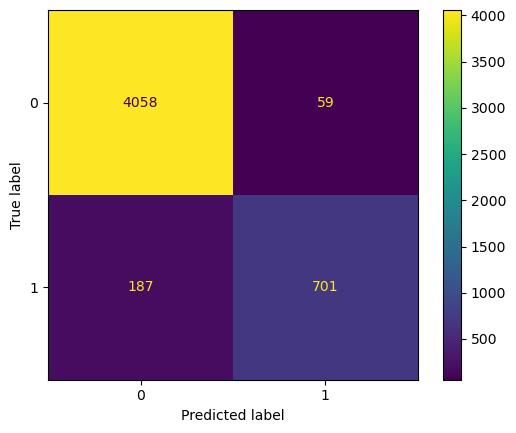

Accuracy:0.951
Precision:0.922
Recall:0.789
F1 Score:0.851


In [60]:
conf_matrix_plot(xgb_cv.best_estimator_, X_val, y_val)

# pacE: Execute Stage

## Step 4. Results and Evaluation

### Summary of model results

#### let's Compare all the alogtithms used together to identify the Champion model

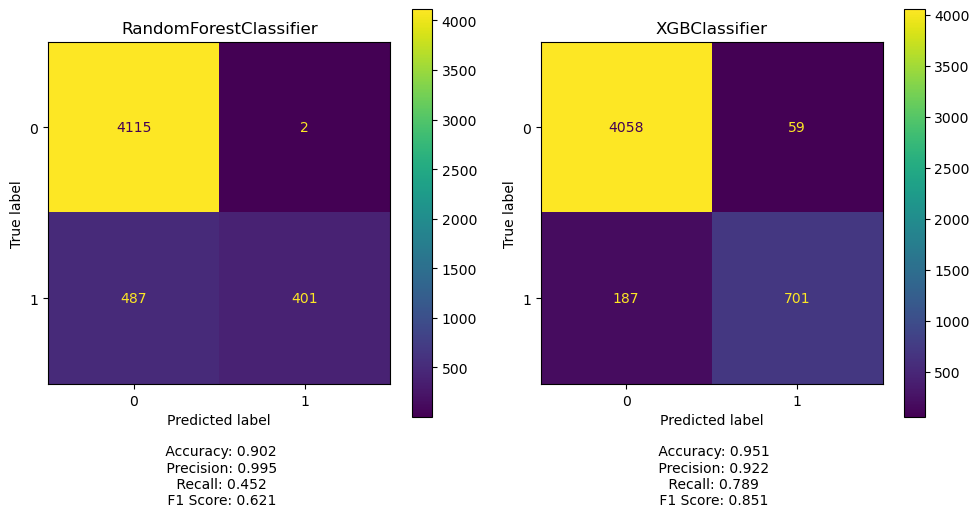

In [61]:
# Collecting our classifiers in a list
classifiers = [rf_val.best_estimator_, xgb_cv.best_estimator_]

# Create a grid of subplots to compare the confusion matrices and accuracy measures
num_classifiers = len(classifiers)

fig, axes = plt.subplots(1, num_classifiers, figsize=(5 * num_classifiers, 5))

# Iterate over each classifier and display its confusion matrix along with its accuracy measures
for i, model in enumerate(classifiers):
    # Compute the confusion matrix
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], values_format='')
    axes[i].set_title(model.__class__.__name__)  # Set the title to the classifier name
    
    # Compute accuracy measures
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Add text annotations for accuracy measures
    textstr = f' \n \n \n \n \n Accuracy: {acc:.3f}\n Precision: {prec:.3f}\n Recall: {rec:.3f}\n F1 Score: {f1:.3f}'
    axes[i].text(0.5, -0.15, textstr, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()


# By comparing the results of the two classifiers used , the champion model with f1-score 0.851 ,  is **XGBOOST** 🏆🥇

Finally , let's look at the random forest feature importance to identify which features were the most useful for the champion model (random forest)

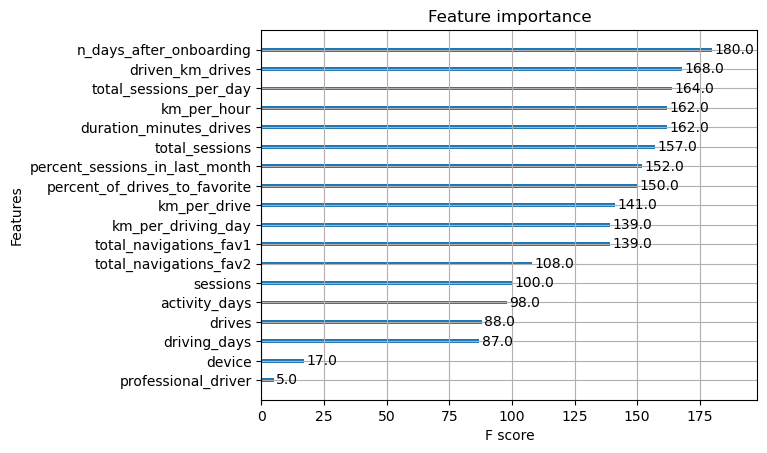

In [66]:
plot_importance(xgb_cv.best_estimator_);

Now let's evaluate the champion model on the unseen test set

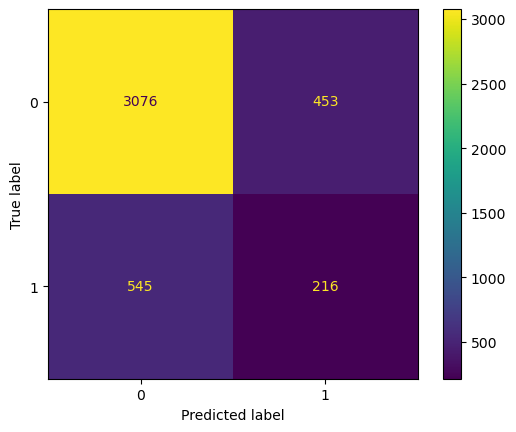

Accuracy:0.767
Precision:0.323
Recall:0.284
F1 Score:0.302


In [63]:
conf_matrix_plot(xgb_cv.best_estimator_, X_test, y_test)

That's quite low 😔

### Conclusion, Recommendations


- RandomForest and XGBOOST were used for modeling , however XGBOOST scored higher than RandomForest on the validation set.


- XGBOOST didn't score as high as it should be on the unseen test set , it scored F1-score 0.302 which seems to be low , so we cannot implement this model at this stage , we should perform other rounds with different tests to improve the accuracy.


- Upon investigating the feature importance for the champion model, we find that 14 out of 18 features are important to be used when training the model , this opens a way to try another round to train the champion model using the most important features.


- Engineering more features , trying other algorithms and performing more advanced EDA might improve the model accuracy